##### *Python libraries used in this notebook*

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from math import log2
import pandas as pd
import heapq

# Implementation of Hoffman`s algorithm

## Abstract
This notebook discusses the Hoffmann algorithm, compares lossy and lossless compression algorithms. Represents Hoffman's algorithm mathematically. A compression method based on the considered algorithm is implemented with Python. The degree of compression of text arrays has been verified through trials.

## 1. Huffman`s algorithm
Huffman coding, named after its inventor David A. Huffman, is a widely used technique in computer science and information theory for achieving lossless data compression. It utilizes a special kind of code called a prefix code, where the bit sequence representing a symbol never appears as the beginning of another symbol's sequence. This algorithm was introduced by Huffman in his 1952 paper titled "A Method for the Construction of Minimum-Redundancy Codes".

### 1.1 Difference between lossless and lossy compression
Digital files can be quite large. To address this issue, compression techniques are employed to reduce file sizes without compromising (**for lossless**) or with some acceptable compromise (**for lossy**) in quality. Two primary methods of compression are lossless and lossy compression.

#### 1.1.1 Lossless Compression 
**Definition:** Lossless compression aims to reduce file size without any loss of data. The decompressed file is an exact replica of the original file.

**How it works:** Lossless compression algorithms identify and eliminate redundant data within the file. Common techniques include:
> - Run-Length Encoding (RLE): Replaces repeated occurrences of a character or sequence with a count and the character/sequence, reducing the number of bits required.
> - Huffman Coding: Assigns shorter codes to frequently occurring characters and longer codes to less frequent ones, minimizing the overall bit usage.
> - Lempel-Ziv-Welch (LZW): Identifies and replaces recurring patterns in the data with shorter codes, further reducing redundancy.

**Pros:** No data is lost, so the original file can be perfectly reconstructed. Essential for applications where data integrity is crucial, like text documents, medical imaging, and some scientific data.\
**Cons:** Generally achieves less compression compared to lossy methods. May not be sufficient for applications requiring extreme reductions in file size.

Lossles compression is used to compress text files (ZIP, GZIP), images (PNG, LZW) and audio (FLAC, ALAC).

#### 1.1.2 Lossy Compression
**Definition:** Lossy compression reduces file size by permanently eliminating some data, particularly data that is considered less important or imperceptible to human senses.

**How it works:** It uses algorithms that remove redundant or less critical information. Common techniques include:
> - Transform Coding: Transforms data into a different domain (like frequency domain), then quantizes and encodes the less significant parts with fewer bits.
> - Quantization: Reduces the precision of less critical data points.
> - Entropy Coding: Further compresses the data after quantization.

**Pros:** Achieves much higher compression ratios compared to lossless methods. Suitable for applications where some loss of quality is acceptable, such as streaming media, online images, and consumer audio.

**Cons:** Some data is permanently lost, which can affect quality, especially at higher compression rates. Decompressed files are not identical to the original; repeated compression and decompression can degrade quality further.

Lossy compression is used to compress images (JPEG), audio (MP3, AAC) and video (MP4).

#### 1.1.3 Key Differences
- **Data Integrity:** Lossless compression retains all original data, while lossy compression sacrifices some data for smaller file sizes.
- **Compression Ratio:** Lossy compression generally achieves higher compression ratios compared to lossless.
- **Use Cases:** Lossless is used where data integrity is crucial; lossy is used where reduced file size is more important than perfect fidelity.

### 1.2 Applicability of lossless compression algoritms
Lossless compression algorithms are appropriate in the following situations:
- **Text Files:** When compressing text documents such as source code, configuration files, or any other textual data where exact reproduction of the original data is essential.
- **Executable Files:** For software distribution, where the integrity of the executable files must be maintained to ensure proper functionality.
- **Database Files:** In scenarios where data precision is critical, such as in database backups and archival, to ensure no data corruption.
- **Medical Imaging:** In medical applications (e.g., medical scans, MRI images) where any data loss could lead to misdiagnosis or incorrect treatment.
- **Scientific Data:** For scientific data and research where exact replication of data is necessary to maintain accuracy and reproducibility of results.
- **Financial Records:** In financial and legal documents where data integrity and accuracy are paramount.
- **Configuration and Log Files:** To ensure that configuration settings and logs are preserved exactly as they were originally recorded.
- **Audio and Image Files for Editing:** When working with audio, image, or video files in professional editing contexts where repeated saving and loading without quality degradation is required.
- **Version Control Systems:** In version control systems like Git, where it’s important to track exact changes in files over time.
- **Data Deduplication:** In scenarios where storage efficiency is achieved by eliminating duplicate copies of repeating data, requiring exact duplicates to be recognized and handled appropriately.

Lossless compression is preferred in these cases because it ensures that the original data can be perfectly reconstructed from the compressed data, maintaining data integrity and accuracy.

## 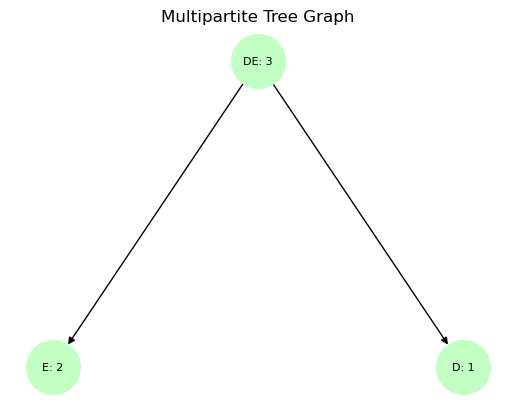2. Huffman`s algorithm theory
### 2.1 Formalized description
**Input**\
We have the number of unique elements in the text that we will apply the algorithm to - Alphabet $A = (a_1, a_2,\dots, a_n)$, which is the symbol alphabet of size n.\
We have the probability of each element, i.e. the frequency of each element divided by the total number of elements - Tuple $W = (w_1, w_2, \dots, w_n)$, which is the tuple of the (positive) symbol weights (usually proportional to probabilities), i.e $w_i = weight(a_i), i \in \{1, 2,\dots, n\}$.

**Output**\
We expect for each element of the alphabet, its code correspondence as a binary code that is unique for each element - Code $C(W) = (c_1, c_2, \dots, c_n)$, which is the tuple of (binary) codewords, where $c_i$ is the codeword for $a_i, i \in \{1, 2, \dots, n\}$.

**Goal**\
The weighted average length of a code element - Length $L(C(W)) = \sum_{i = 1}^n w_i lenght(c_i)$ be the weighted path length of code $C$. Condition: $L(C(W)) \leq L(T(W))$ any arbitrary code that could also be applied $T(W)$.

**Example**\
We have the following string abcsddeeee, ten characters in total but five are unique. The following table presents the probability distribution for each unique symbol, the code word for each symbol (the way to determine the code words will be discussed later in a Hoffmann tree). It can be seen that the length of the code words is inversely proportional to the probability of encountering this symbol. The last row shows that the weighted average codeword length is 2.20 bits.

|Set       |element       |1   | 2  |3   | 4  | 5  |sum       |
-----------|--------------|----|----|----|----|----|----------|
|Input (A) | $(a_i)$      |a   |b   |c   |d   |e   | -      |
|Input (W) | $(w_i)$      |0.10|0.10|0.20|0.20|0.40|  = 1        |
|Output C  | $(c_i)$      |010 |011 |11  |00  |10  |  -       |
|Output C  | $(l_i)$      |3   |3   |2   |2   |2   |    -       |
|Output C  | $(l_i * w_i)$|0.30|0.30|0.40|0.40|0.80|L(C) = 2.20|

### 2.2 Information entropy (Shannon entropy)
The concept of information entropy was introduced by Claude Shannon in his 1948 paper "A Mathematical Theory of Communication", and is also referred to as Shannon entropy. Shannon's theory defines a data communication system composed of three elements: a source of data, a communication channel, and a receiver. The "fundamental problem of communication" – as expressed by Shannon – is for the receiver to be able to identify what data was generated by the source, based on the signal it receives through the channel. Shannon considered various ways to encode, compress, and transmit messages from a data source, and proved in his source coding theorem that the entropy represents an absolute mathematical limit on how well data from the source can be losslessly compressed onto a perfectly noiseless channel. Shannon strengthened this result considerably for noisy channels in his noisy-channel coding theorem.\
In information theory, the entropy of a random variable is the average level of "information", "surprise", or "uncertainty" inherent to the variable's possible outcomes. Given a discrete random variable $\Chi$,  which takes values in the set $\chi$  and is distributed according to $p: \chi \rightarrow [0,1]$, the entopy is:
$$\Eta(X) := - \sum_{x\in\chi} p(x) \log p(x)$$
where $\sum$ denotes the sum over the variable's possible values. The choice of base for $\log$, the logarithm, varies for different applications. Base 2 (this base will be used below) gives the unit of bits (or "shannons"), while base e gives "natural units" nat, and base 10 gives units of "dits", "bans", or "hartleys". An equivalent definition of entropy is the expected value of the self-information of a variable.

The core idea of information theory is that the "informational value" of a communicated message depends on the degree to which the content of the message is surprising. If a highly likely event occurs, the message carries very little information. On the other hand, if a highly unlikely event occurs, the message is much more informative. For instance, the knowledge that some particular number will not be the winning number of a lottery provides very little information, because any particular chosen number will almost certainly not win. However, knowledge that a particular number will win a lottery has high informational value because it communicates the occurrence of a very low probability event.

The information content, also called the surprisal or self-information, of an event $E$ is a function which increases as the probability $𝑝(𝐸)$ of an event decreases. When $𝑝(𝐸)$ is close to 1, the urprisal of the event is low, but if $𝑝(𝐸)$ is close to 0, the surprisal of the event is high. This relationship is described by the function:
$$\log\left(\frac{1}{p(E)}\right),$$
where $\log$ is the logarithm, which gives 0 surprise when the probability of the event is 1.\
Hence, we can define the information, or surprisal, of an event $𝐸$ by:
$$I(E) = -\log_2(p(E)),$$
or equivalently,
$$I(E) = \log_2\left(\frac{1}{p(E)}\right).$$
Entropy measures the expected (i.e., average) amount of information conveyed by identifying the outcome of a random trial.  This implies that rolling a die has higher entropy than tossing a coin because each outcome of a die toss has smaller probability $p = \frac{1}{6}$ than each outcome of a coin toss $𝑝 = \frac{1}{2}$.

Now we will calculate the entropy of all symbols from the example in point 2.1:
$$H(A) = -\sum_{w_i>0} w_i \log_2 w_i = (-0.10\log_2 0.10) + (-0.10\log_2 0.10) + (-0.20\log_2 0.20) + (-0.20\log_2 0.20) + (-0.40\log_2 0.40) 	\approx 2.12 $$
As a consequence of Shannon’s source coding theorem, the entropy is a measure of the smallest codeword length that is theoretically possible for the given alphabet with associated weights. In this example, the weighted average codeword length is 2.20 bits per symbol, only slightly larger than the calculated entropy of 2.12 bits per symbol. So not only is this code optimal in the sense that no other feasible code performs better, but it is very close to the theoretical limit established by Shannon.

### 2.3 Huffman tree
Huffman coding assigns codes to characters such that the length of the code depends on the relative frequency or weight of the corresponding character. Huffman codes are of variable-length, and prefix-free (no code is prefix of any other). Any prefix-free binary code can be visualized as a binary tree with the encoded characters stored at the leaves.

A Huffman coding tree or Huffman tree is a full binary tree in which each leaf of the tree corresponds to a letter in the given alphabet.

Define: the weighted path length of a leaf to be its weight times its depth. The Huffman tree is the binary tree with minimum external path weight, i.e., the one with the minimum sum of weighted path lengths for the given set of leaves. So the goal is to build a tree with the minimum external path weight.

Building a Huffman tree involves the following steps:
> - All unique characters from the encoding string are extracted, for each character the frequency of occurrence is determined, then it is sorted by size (a priority queue is created) from the lowest value to the highest, i.e. nodes are created, each of which contains a key - the sign and a value - the frequency.
> - The first two nodes (those with the least weight) are removed. A new node is created (the root of the two nodes) that has a left and right child of the two nodes and a value that is the sum of the value of the two children. The new node is then added to the collection at the appropriate location, according to its value.
> - Step two is repeated until there is only one node left in the queue (priority queue), which is the root of the tree.
> - Finally, the tree’s left and right edges are numbered 0 and 1, respectively. For each leaf node, the entire tree is traversed, and the corresponding 1 and 0 are appended to their code until a leaf node is encountered.
> - Once we have the unique codes for each unique character in the text, we can replace the text characters with their codes. These codes will be stored in bit-by-bit form, which will take up less space than text.

#### 2.3.1 Constructing a Huffman tree
Let’s create a Huffman tree on the following string: ABABCACDEABE\
We have the following sequence of symbols:
> 1. D - 1
> 2. E - 2
> 3. C - 2
> 4. B - 3
> 5. A - 4

We remove the two nodes with the smallest value - D and E and create a new node DE with a value of 3.


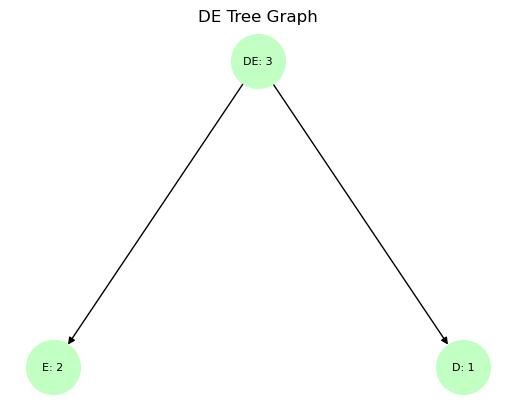

In [5]:
tree_dict = {
        1: {
            "D: 1":"DE: 3",
            "E: 2":"DE: 3"
            }
        }

# Create a NextworkX directed graph
g = nx.DiGraph()
g.add_nodes_from(['DE: 3'], subset=1)
g.add_nodes_from(tree_dict[1].keys(), subset=0)

# Add Title to Plot
plt.title('DE Tree Graph')

# Create a list of the edges
edges = []
for subset_stuff in tree_dict.values():
    for node, prev_node in subset_stuff.items():
        edges.append((prev_node, node))

# Draw the nodes with the multipartite layout
pos = nx.multipartite_layout(g, align='horizontal')
nx.draw(g, pos, with_labels=True, node_size=1500, node_color='#c2ffc2', font_size=8)

# Draw the edges with the multipartite layout
nx.draw_networkx_edges(g, pos, edgelist=edges, arrows=None, node_size=1500)
# Show the plot
plt.show()

Now have the following sequence:
> 1. C - 2
> 2. DE - 3
> 3. B - 3
> 4. A - 4

Again we remove the two nodes with the smallest value - C and DE and create a new node CDE with a value of 5, and the following sequence:
> 1. B - 3
> 2. A - 4
> 3. CDE - 5

Again we remove the two nodes with the smallest value - B and A and create a new node BA with a value of 7, and the following sequence:
> 1. CDE - 5
> 2. BA - 7

We also combine the last two nodes and get one node CDEBA - 12, which is the root of the tree.

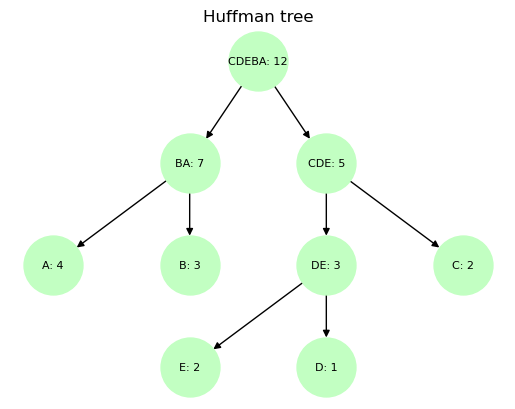

In [6]:
tree_dict = {
        1: {
            "CDE: 5":"CDEBA: 12",
            "BA: 7":"CDEBA: 12"
            },
         2: {
            "C: 2":"CDE: 5",
             "DE: 3":"CDE: 5",
            "B: 3":"BA: 7",
             "A: 4":"BA: 7"
            },
         3: {
            "D: 1":"DE: 3",
             "E: 2":"DE: 3"
            }
        }

# Create a NextworkX directed graph
g = nx.DiGraph()
g.add_nodes_from(['CDEBA: 12'], subset=3)
g.add_nodes_from(tree_dict[1].keys(), subset=2)
g.add_nodes_from(tree_dict[2].keys(), subset=1)
g.add_nodes_from(tree_dict[3].keys(), subset=0)

# Add Title to Plot
plt.title('Huffman tree')

# Create a list of the edges
edges = []
for subset_stuff in tree_dict.values():
    for index, (node, prev_node) in enumerate(subset_stuff.items(), start = 0):
        edges.append((prev_node, node, (0, 1) [index % 2 != 1]))

# Create a list of the lebels of edges
edga_labels = dict([((a,b,),v) for a,b,v in edges])

# Draw the nodes with the multipartite layout
pos = nx.multipartite_layout(g, align='horizontal')
nx.draw(g, pos, with_labels=True, node_size=1800, node_color='#c2ffc2', font_size=8)

# Draw the edges with the multipartite layout
nx.draw_networkx_edges(g, pos, edgelist=edges, arrows=None, node_size=1800)

# Show the plot
plt.show()

When all characters are stored in the leaf and each internal (non-leaf) node has two children, the encoding induced by the 0/1 convention described above satisfies a very important property called the prefix property, which states that there is no bit encoding character sequence is the prefix of the bit sequence encoding of every other character. This makes it possible to decode a bitstream using the encoding tree by following root-to-leaf paths. Now we number the left edges with 0 and the right edges with 1.

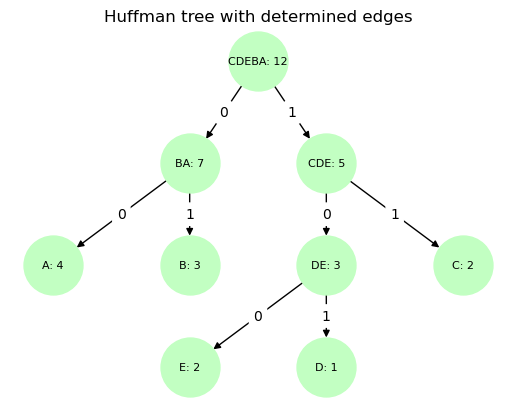

In [7]:
# Add Title to Plot
plt.title('Huffman tree with determined edges')

# Create a list of the lebels of edges
edga_labels = dict([((a,b,),v) for a,b,v in edges])

# Draw the nodes with the multipartite layout
pos = nx.multipartite_layout(g, align='horizontal')
nx.draw(g, pos, with_labels=True, node_size=1800, node_color='#c2ffc2', font_size=8)

# Draw the edges with the multipartite layout
nx.draw_networkx_edges(g, pos, edgelist=edges, arrows=None, node_size=1800)
nx.draw_networkx_edge_labels(g,pos,edge_labels=edga_labels, rotate=False)

# Show the plot
plt.show()

## Finally, we obtain the codeword for each symbol, as the string from the numbering of the edges from the root of the tree to the corresponding leaf, and obtain the following:
> - A - 00,
> - B - 01,
> - C - 11,
> - E - 100,
> - D - 101,

Applying this code to the string from the example ABABCACDEABE, we get the following encoded string: 000100011100111011000001100, which has 27 bits. Decoding is done starting from left to right taking one symbol at a time until a code word is obtained where the corresponding symbol is decoded and in the same way continues with the next one until the whole string is decoded. As can be seen by means of the Huffman tree such codewords are constructed that none of them is a prefix of another: 00-A,01-B,00-A,01-B,11-C,00-A,11-C,101-D,100-E,00-A,01-B,100-E.


We will now calculate the weighted average achieved symbol length in the encoded string and the entropy of the encoded string by finding the frequency and code length of each symbol.
|element        |A    | B  |C    | E   | D   |sum       |
|---------------|-----|----|-----|-----|-----|----------|
| $(w_i)$ weight|0.333|0.25|0.167|0.167|0.083|  = 1     |
| $(l_i)$ length|2    |2   |2    |3    |3    |    -     |
| $(l_i * w_i)$ |0.666|0.50|0.334|0.501|0.249|L(C) = 2.25|

$$H(A) = (-0.333\log_2 0.333) + (-0.25\log_2 0.25) + (-0.167\log_2 0.167) + (-0.167\log_2 0.167) + (-0.083\log_2 0.083) 	\approx 2.19 $$

The weighted average length of the coded string is approximately equal to the Shannon entropy, indicating that the codewords generated via the Huffman tree are the optimal length code for that string.

#### 2.3.2 Huffman tree information storage
We will look at passing information about non-canonical code, ie. different Huffman trees are created for different files (strings) and the codeword for the same symbol may be different - it depends solely on the constructed Huffman tree. Therefore, sufficient initial information must be stored in the compressed file to be used by the decompression program. Essentially, the tree used to compress the original file must be preserved. This is because the decompression program needs the exact same tree to decode the data. The topology information is called the header. There are three unsigned integers at the beginning of the compressed:
> - The total number of characters in the compressed file, as a 4-byte unsigned integer.
> - The total number of characters storing the header information, i.e., the topology of the Huffman coding tree, as a 4-byte unsigned integer.
> - The total number of characters in the original uncompressed file, as a 4-byte unsigned integer.

After the three unsigned integers, the header information or Huffman encoding tree topology is stored and then followed by the encoding of the original text using Huffman codes. We described the encoding of the original text in section 2.3.1. We now focus on how the Huffman coding tree topology is stored. To store the tree at the beginning of the file, a post-order traversal is used, recording each node visited. When you encounter a leaf node, type 1 followed by the ASCII character of the leaf node. When you encounter a node that is not a leaf, you write a 0. To indicate the end of the Huffman coding tree, we write another 0. After the header comes the body, which contains the encoded string

For the string used in the above example, the header is 1A1B01E1D01C000. In this example, we use characters 0 and 1 to distinguish between non-leaf and leaf nodes (and 0 to indicate the end of a topology). As there are five leaf nodes in the example, there are five 1’s, four 0’s for non-leaf nodes, and another one 0 to indicate that we have reached the end of a topology. This approached used a total of 7 bytes for Huffman coding tree and 22 bytes for header and body and not the encoded character string is 12 bytes in size.

An alternative way of conveying information about a Huffman tree is by specifying for each unique symbol its frequency, i.e. in the example we are considering, the representation of the tree would look like this: A4B3E2C2D1, but this way is more inefficient because using more integer values ​​increases the size of the encoded file - in the example we have 5 integers and 5 elements, the total size of which is 25 bytes.

**When decoding an encoded file, the following steps should be performed:**
- Building a Huffman encoding tree using the information in the header - from the second number at the beginning of the encoded file, the total number of characters in the header is taken, and based on the topology of the tree, it is constructed and the code word for each element is found.
- Then, starting to read from left to right, each new bit of the body of the encoded file is added to an array and checked to see if the elements in the array, in their order, match any code word. If there is a match, the decoded symbol is written, the array is reset to zero, and consecutive body bits are added from the zero element until all the body bits are traversed. It should be borne in mind that usually the information stored in files is in bytes, which have 8 bits each, i.e. there is a possibility that the last byte is not completely filled with information from the body, and the remaining free bits of the last file are filled with 0 bits. Information to which bit exactly reaches the body is obtained by subtracting the second from the first number at the beginning of the coded file and / or monitoring the number of decoded characters and when their number is equal to the third number at the beginning of the coded file, the decoding is finished.

If we look at the above example, where we have the following coded string 000100011100111011000001100, we start from left to right adding the bits: 0 + 0 and get 00 which corresponds to "A", write down "A", remove the two bits and start adding again 0 + 1 , which corresponds to "B", we write "B" and have decoded "AB", remove the two bits and start a new addition, and so on until we go through all the bits.

## 3. Implementing of Huffman`s algorithm ##
For convenience, we'll implement a method that will encode, generate a Huffman tree typology, and decode a string rather than a file. It will not have a significant impact on the analysis, because in addition to the coded string and the tree topology, there are three more numbers in the file encoding, the role of which was explained in point 2.3.2. 

In [58]:
# HuffmanNode Class
class Huffman_node :
    # Constructor, initializes a node with a character, frequency, left and right child nodes
    def __init__(self, ch, frequency,  left,   right) :
        self.ch = ch
        self.frequency = frequency
        self.left = left
        self.right = right
 
    # String representation of the node, showing character and frequency
    def __str__(self):
    	return "(" + str(self.ch) + ", " + str(self.frequency) + ")"  
 
class Huffman_coding :
 # Method to get the root of the Huffman tree for the input string
    def get_root(self, input) :
        freq_map = self.build_frequency_map(input) # Step 1: Build frequency map
        node_queue = self.sort_by_frequence(freq_map)  # Step 2: Sort nodes by frequency
        self.root = self.build_tree(node_queue) # Step 3: Build the Huffman tree
        return self.root
        
    # Method to get the Huffman codes for all characters in the input string
    def get_code(self,root) :
        code_map = self.create_huffman_code(root) # Create Huffman codes
        return code_map
 
   # Step 1: Create character frequency map from input string
    def build_frequency_map(self, input) :
        map = {}
        for c in input:
            map[c] = map.get(c,0) + 1 # Increment frequency count for each character
        return map
 
    # Step 2: Create a queue of nodes from the frequency map and sort by frequency
    def sort_by_frequence(self, map) :
        queue = []
        for k, v in map.items():
            queue.append(Huffman_node(k, v, None, None))  # Create a node for each character     
        queue.sort(key = lambda x: x.frequency) # Sort the nodes by frequency
        return queue  
 
    #Step 3: Build frequency-sorted binary tree from sorted queue, return root    
    def build_tree(self, node_queue) :             
        while len(node_queue) > 1:
            node1 = node_queue.pop(0) # Get the node with the lowest frequency
            node2 = node_queue.pop(0) # Get the node with the second lowest frequency
            node = Huffman_node('', node1.frequency + node2.frequency, node1, node2) # Merge nodes
            node_queue.append(node) # Add the merged node back to the queue
            node_queue.sort(key=lambda x: x.frequency)  # Re-sort the queue
        return node_queue.pop(0) # The last remaining node is the root
 
	# Step 4: Create a Huffman code map by performing a pre-order traversal of the tree
    def create_huffman_code(self, node) :
        map = {}
        if node.left == None and node.right == None : # If have got one node
            map[node.ch] = '0'
        else:
            self.create_code_rec(node, map, "") # Helper method to create codes recursively
        return map
    
    # Pre-order traversal of the tree using recursion
    def create_code_rec(self, node, map, s) :
        if node.left == None and node.right == None :
            map[node.ch] = s # If leaf node, add code to map
            return
        self.create_code_rec(node.left, map, s + '0') # Traverse left with '0'
        self.create_code_rec(node.right, map, s + '1') # Traverse right with '1'
 
    # Step 5: Use Huffman code to encode the input string
    def encode(self, codeMap, input) :
        s = ""
        for  i in range(0, len(input)):
            s += code_map.get(input[i]) # Get code for each character
        return s
 
    # Step 6: Decode the encoded string using the Huffman tree
    def decode(self, coded) :
        s = ""
        curr = self.root
        if curr.left == None and curr.right == None: # If have got one node
            for  i in range (0, len(coded)) :
                s += curr.ch # If leaf node, append character to result
            return s
        for  i in range (0, len(coded)) :
            curr = curr.right if coded[i] == '1' else curr.left # Traverse tree according to the code
            if curr.left == None and curr.right == None:
                s += curr.ch # If leaf node, append character to result
                curr = self.root # Reset to root for next character
        return s

    # Method to traverse the Huffman tree and encode its topology
    def traverse_and_encode(self, node):
        result = []
        self._traverse_and_encode_helper(node, result)
        return ''.join(result)

    # Helper method for the traversal
    def _traverse_and_encode_helper(self, node, result):
        if node is None:
            return

        if node.left is None and node.right is None:
            # Leaf node: append 0 and the symbol bits
            result.append('1')
            result.append(node.ch)
        else:
            # Internal node: append 1            
            self._traverse_and_encode_helper(node.left, result)
            self._traverse_and_encode_helper(node.right, result)
            result.append('0')

In the above code, for convenience, we use 0 and 1 as numbers instead of bit values, so we will only use letters of the English alphabet for encoding strings. This limitation will not hinder the analysis on the efficiency of Huffman tree encoding, but it greatly simplifies the implementation. With the string "ABABABABAB" we will illustrate the possibilities that this implementation allows us.

In [108]:
string = "ABABABABAB"
result = {}

huffman = Huffman_coding() 

root = huffman.get_root(string)
traverce = huffman.traverse_and_encode(root) 
code_map = huffman.get_code(root)
uniq_symbol_input = len(code_map)
encoded = huffman.encode(code_map, input)
decode = huffman.decode(encoded)    
compresion = (len(encoded)  + (len(code_map) * 8) + (len(traverce) - len(code_map)) + 1)/ ((len(decode) * 8)) * 100

result["Origin string"] = input
result["Tree traverce"] = traverce
result["Encoded string"] = encoded
result["Decode string"] = decode
result["Compresion in percentage"] = compresion
for key, value in result.items():
    print(f"{key}: {value}")    

Origin string: ABABABABAB
Tree traverce: 1A1B0
Encoded string: 0101010101
Decode string: ABABABABAB
Compresion in percentage: 37.5


It is necessary to clarify the way of calculating the compression percentage, since as already mentioned, the implementation does not use bits but 0 and 1. This is done by the following formula:
$$C = \frac{L_{encod} + (N_{unq} * 8) + (L_{trav} - N_{unq}) + 1 }{L_{inp} * 8} * 100$$
where:
- $C$ the compression ratio in percent;
- $L_{encod}$ the length of the encoded string;
- $N_{unq}$ the unique characters in the input string;
- $L_{trav}$ the number of characters in the string for the Huffman tree travers;
- $L_{inp}$ the length of the input string.

Alphanumeric characters are multiplied by 8 because they are assumed to be one byte in size. The formula does not include the size of the first three integers, the function of which is explained in point 2.3.2, because they have a constant value of 12 bytes. Also no check is done if the number of bits is a multiple of 8, as this would have minimal impact.

Alphanumeric characters are multiplied by 8 because they are assumed to be one byte in size. The formula does not include the size of the first three integers, the function of which is explained in point 2.3.2, because they have a constant value of 12 bytes. Also no check is done if the number of bits is a multiple of 8, as this would have minimal impact.

## 4. Study of the algorithm
For this purpose, we will create 5 strings of 10 characters each, and the probability distribution will be as follows:
1. 0.1, i.e. 10 unique characters - "ABCDEFGJVH";
2. 0.2, i.e. 5 unique characters with two repetitions each - "AABBCCDDEE";
3. 0.3, 0.3, 0.4, i.e. three unique characters, the first and second with three repetitions, and the third with 4 - "AAABBBCCCC";
4. 0.5, i.e. two unique characters with five repetitions each - "AAAAABBBBB";
5. 1, i.e. one unique character with 10 repetitions - "AAAAAAAAAA".

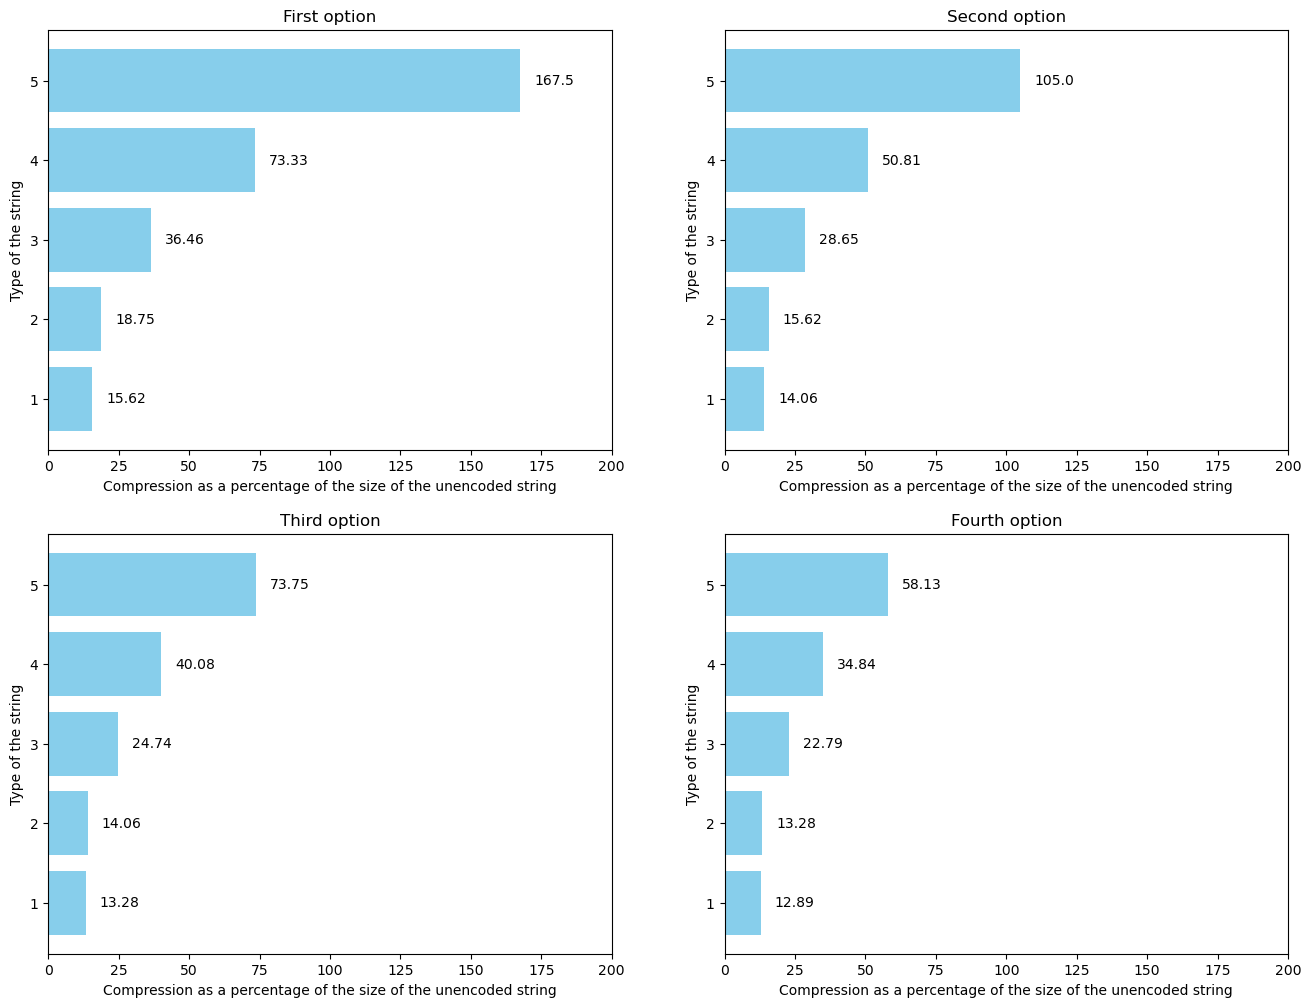

In [179]:
strings = [ "AAAAAAAAAA", "AAAAABBBBB", "AAABBBCCCC", "AABBCCDDEE", "ABCDEFGJVH"]

def get_compression_ratio(input):
    huffman = Huffman_coding()
    result = {}
    for indes, string in enumerate(input, start = 0):
        root = huffman.get_root(string)
        traverce = huffman.traverse_and_encode(root) 
        code_map = huffman.get_code(root)
        uniq_symbol_input = len(code_map)
        encoded = huffman.encode(code_map, string)
        decode = huffman.decode(encoded)    
        compresion = (len(encoded)  + (len(code_map) * 8) + (len(traverce) - len(code_map)) + 1)/ ((len(decode) * 8)) * 100
        result[indes + 1] = f"{compresion:.2f}"
    return result

# Option with initial list strings
first_option = get_compression_ratio(strings)

# Option with doubled strings
for i in range(0, len(strings)):
    strings[i] *= 2

second_option = get_compression_ratio(strings)

# Option with quadrupled initial strings
for i in range(0, len(strings)):
    strings[i] *= 2
    
third_option = get_compression_ratio(strings)

# Option the original strings multiplied by eight
for i in range(0, len(strings)):
    strings[i] *= 2
    
fourth_option = get_compression_ratio(strings)

# Data first graph
x_first_option = list(first_option.keys())
y_first_option = [float(value) for value in first_option.values()]

# Data second graph
x_second_option = list(second_option.keys())
y_second_option = [float(value) for value in second_option.values()]

# Data third graph
x_third_option = list(third_option.keys())
y_third_option = [float(value) for value in third_option.values()]

# Data fourth graph
x_fourth_option = list(fourth_option.keys())
y_fourth_option = [float(value) for value in fourth_option.values()]

plt.figure(figsize=(16, 12))

# First graph
plt.subplot(2, 2, 1)
plt.barh(x_first_option, y_first_option,color='skyblue')
plt.xlim(0, 200)
for i in range(len(x_first_option)):
    plt.text(y_first_option[i] + 5, x_first_option[i], str(y_first_option[i]), va='center')
plt.xlabel('Compression as a percentage of the size of the unencoded string')
plt.ylabel('Type of the string')
plt.title('First option')

# Second graph
plt.subplot(2, 2, 2)
plt.barh(x_second_option, y_second_option,color='skyblue')
plt.xlim(0, 200)
for i in range(len(x_second_option)):
    plt.text(y_second_option[i] + 5, x_second_option[i], str(y_second_option[i]), va='center')
plt.xlabel('Compression as a percentage of the size of the unencoded string')
plt.ylabel('Type of the string')
plt.title('Second option')

# Third graph
plt.subplot(2, 2, 3)
plt.barh(x_third_option, y_third_option,color='skyblue')
plt.xlim(0, 200)
for i in range(len(x_third_option)):
    plt.text(y_third_option[i] + 5, x_third_option[i], str(y_third_option[i]), va='center')
plt.xlabel('Compression as a percentage of the size of the unencoded string')
plt.ylabel('Type of the string')
plt.title('Third option')

# Fourth graph
plt.subplot(2, 2, 4)
plt.barh(x_fourth_option, y_fourth_option,color='skyblue')
plt.xlim(0, 200)
for i in range(len(x_fourth_option)):
    plt.text(y_fourth_option[i] + 5, x_fourth_option[i], str(y_fourth_option[i]), va='center')
plt.xlabel('Compression as a percentage of the size of the unencoded string')
plt.ylabel('Type of the string')
plt.title('Fourth option')

plt.show()

For all strings, doubling their length increases the encoding efficiency. This is most clearly evident in the fifth string, whose distribution of elements is 10 percent each. In the first option, which is practically 10 characters, each of which is unique, compression leads to the opposite effect - the size of the file with the compressed code will be larger than that of the source. This is also preserved in the second variant, and even in the third the size of the compressed file will be smaller than the original one (with the proviso that the effect of the three initial numbers is not taken into account). It is clearly seen that doubling the size of the string slows down the rate of increase in compression rate, and this is true for all strings. Another trend that stands out is regarding the number of uncal sivols in each string. The code is most efficient when the first string has only one unique character, and the fewer unique characters in the string, the higher the percentage of compression, but when doubling the string while preserving the frequency distribution, the percentage increase in the rate of compression is lower. The most efficient code is the first string that has only one unique character.

Analysis confirms that the efficiency of coding with the Huffman algorithm depends on the total size of coded data, the number of unique symbols and their frequency distribution. Increasing the data volume while preserving the number of unique symbols and their frequency distribution increases the compression ratio. Also, reducing the number of unique symbols while maintaining the data size and without significantly changing the distribution leads to an increase in compression.

For all strings, doubling their length increases the encoding efficiency. This is most clearly evident in the fifth string, whose distribution of elements is 10 percent each. In the first option, which is practically 10 characters, each of which is unique, compression leads to the opposite effect - the size of the file with the compressed code will be larger than that of the source. This is also preserved in the second variant, and even in the third the size of the compressed file will be smaller than the original one (with the proviso that the effect of the three initial numbers is not taken into account). It is clearly seen that doubling the size of the string slows down the rate of increase in compression rate, and this is true for all strings. Another trend that stands out is regarding the number of uncal sivols in each string. The code is most efficient when the first string has only one unique character, and the fewer unique characters in the string, the higher the percentage of compression, but when doubling the string while preserving the frequency distribution, the percentage increase in the rate of compression is lower. The most efficient code is the first string that has only one unique character
Analysis confirms that the efficiency of coding with the Huffman algorithm depends on the total size of coded data, the number of unique symbols and their frequency distribution. Increasing the data volume while preserving the number of unique symbols and their frequency distribution increases the compression ratio. Also, reducing the number of unique symbols while maintaining the data size and without significantly changing the distribution leads to an increase in compression.

In [102]:
for i in range(0, len(strings)):
    strings[i] *= 2

strings

['aabbccddeeaabbccddee',
 'aaaaabbbbbaaaaabbbbb',
 'aaaabbbbbbaaaabbbbbb',
 'aabbbbbbbbaabbbbbbbb',
 'qwertyuiopqwertyuiop',
 'aaaaaaaaaaaaaaaaaaaa',
 'ABABABABABABABABABAB']

In [ ]:
c = [4,3,2,2,1]

b = [i/12 for i in c]
print(b)

c = [-i * log2(i) for i in b]
print(sum(c))


In [ ]:
a= [2, 4, 8, 16]
b = [i * log2(i) for i in a]
print(b)

### References

1. <a href="https://en.wikipedia.org/wiki/Huffman_coding">Wikipedia - Huffman`s coding</a>
2. <a href="https://en.wikipedia.org/wiki/Lossy_compression">Wikipedia - Lossy compression</a>
3. <a href="https://en.wikipedia.org/wiki/Lossless_compression">Wikipedia - Lossless compression</a>
4. <a href="https://www.khanacademy.org/computing/computers-and-internet/xcae6f4a7ff015e7d:digital-information/xcae6f4a7ff015e7d:data-compression/a/lossy-compression">Khanacademy - Lossy compression</a>
5. <a href="https://en.wikipedia.org/wiki/Entropy_(information_theory)">Wikipedia - Entropy</a>
6. <a href="https://https://engineering.purdue.edu/ece264/17au/hw/HW13?alt=huffman">Huffman Coding</a>
